In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from astropy.nddata import CCDData
from ccdproc import trim_image

from apextract import trace, extract
from fluxcal import standard_sensfunc, apply_sensfunc

In [9]:
stdstar = 'bd284211.dat' # catalog version of flux standard

fcal = 'apo05/05may31.0020r.fits' # Flux std star observation

from astropy import units as u
img = CCDData.read(fcal, unit=u.adu)
# put in units of ADU/s
img.data = img.data / (img.header['EXPTIME'])
img.unit = u.adu / u.s

# trim off bias section
img = trim_image(img, fits_section=img.header['DATASEC'])


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<ErrorbarContainer object of 3 artists>

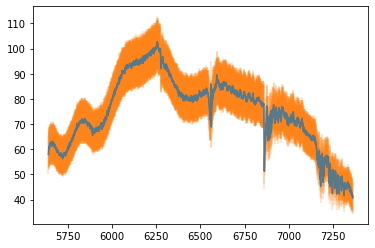

In [10]:
# Trace & Extract the standard star spectrum. See the extract example demo for more details
tr = trace(img, display=False, nbins=25)

flux_std, sky_std, ferr_std = extract(img, tr, display=False, 
                                      apwidth=8, skysep=3, skywidth=7)

# this data comes from the APO DIS red channel, which has wavelength axis backwards
# (despite not mentioning in the header)
wapprox = (np.arange(img.shape[1]) - img.shape[1]/2)[::-1] * img.header['DISPDW'] + img.header['DISPWC']

plt.plot(wapprox, flux_std - sky_std)
plt.errorbar(wapprox, flux_std - sky_std, yerr=ferr_std, alpha=0.25)

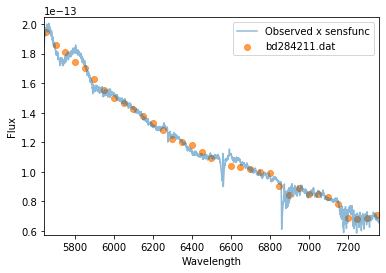

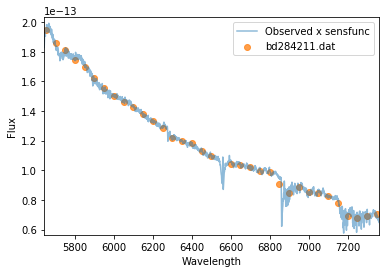

In [5]:
# sensfunc_spl = standard_sensfunc(wapprox, flux_std - sky_std, 
#                                  stdstar='bd284211.dat', display=True, mode='spline')
sensfunc_lin = standard_sensfunc(wapprox, flux_std - sky_std, 
                                 stdstar='/spec50cal/bd284211.dat', display=True, mode='linear')

Though it's more noisy, the linear interpolation looks better in the observed x sensfunc curve in this case. I'd probably go with the linear here, and for quick-look scenarios. I personally don't like the polynomial case usually (not shown).

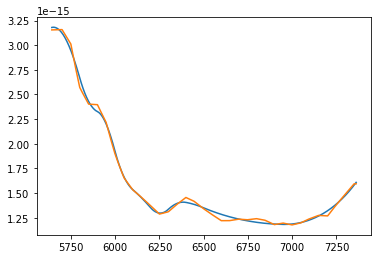

In [11]:
# the actual sensitivity function(s), which in theory include some crude information about 
# the flat fielding (response) - though the reference spectrum is very coarse.

plt.plot(wapprox, sensfunc_spl)
plt.plot(wapprox, sensfunc_lin)